Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/content/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

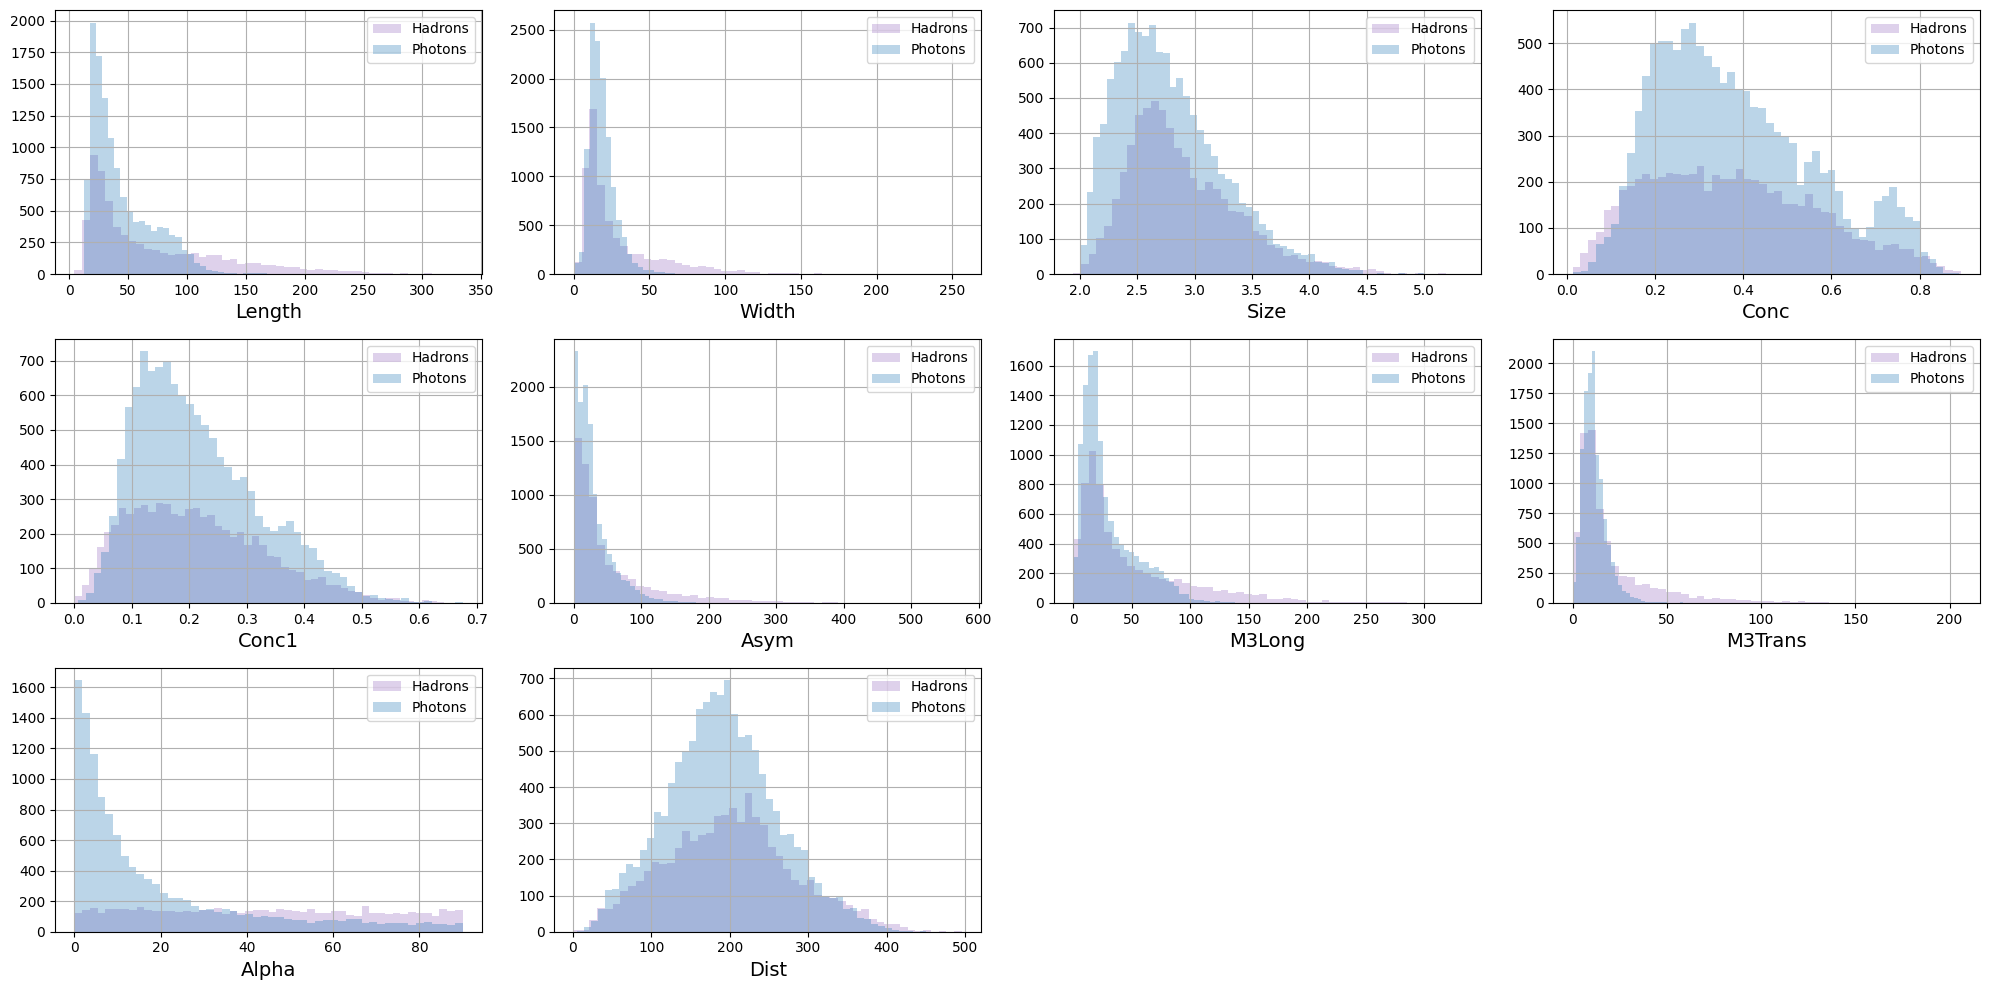

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Сравним распределения train/test

Проиллюстрируйте распределение y внутри train и test выборки.

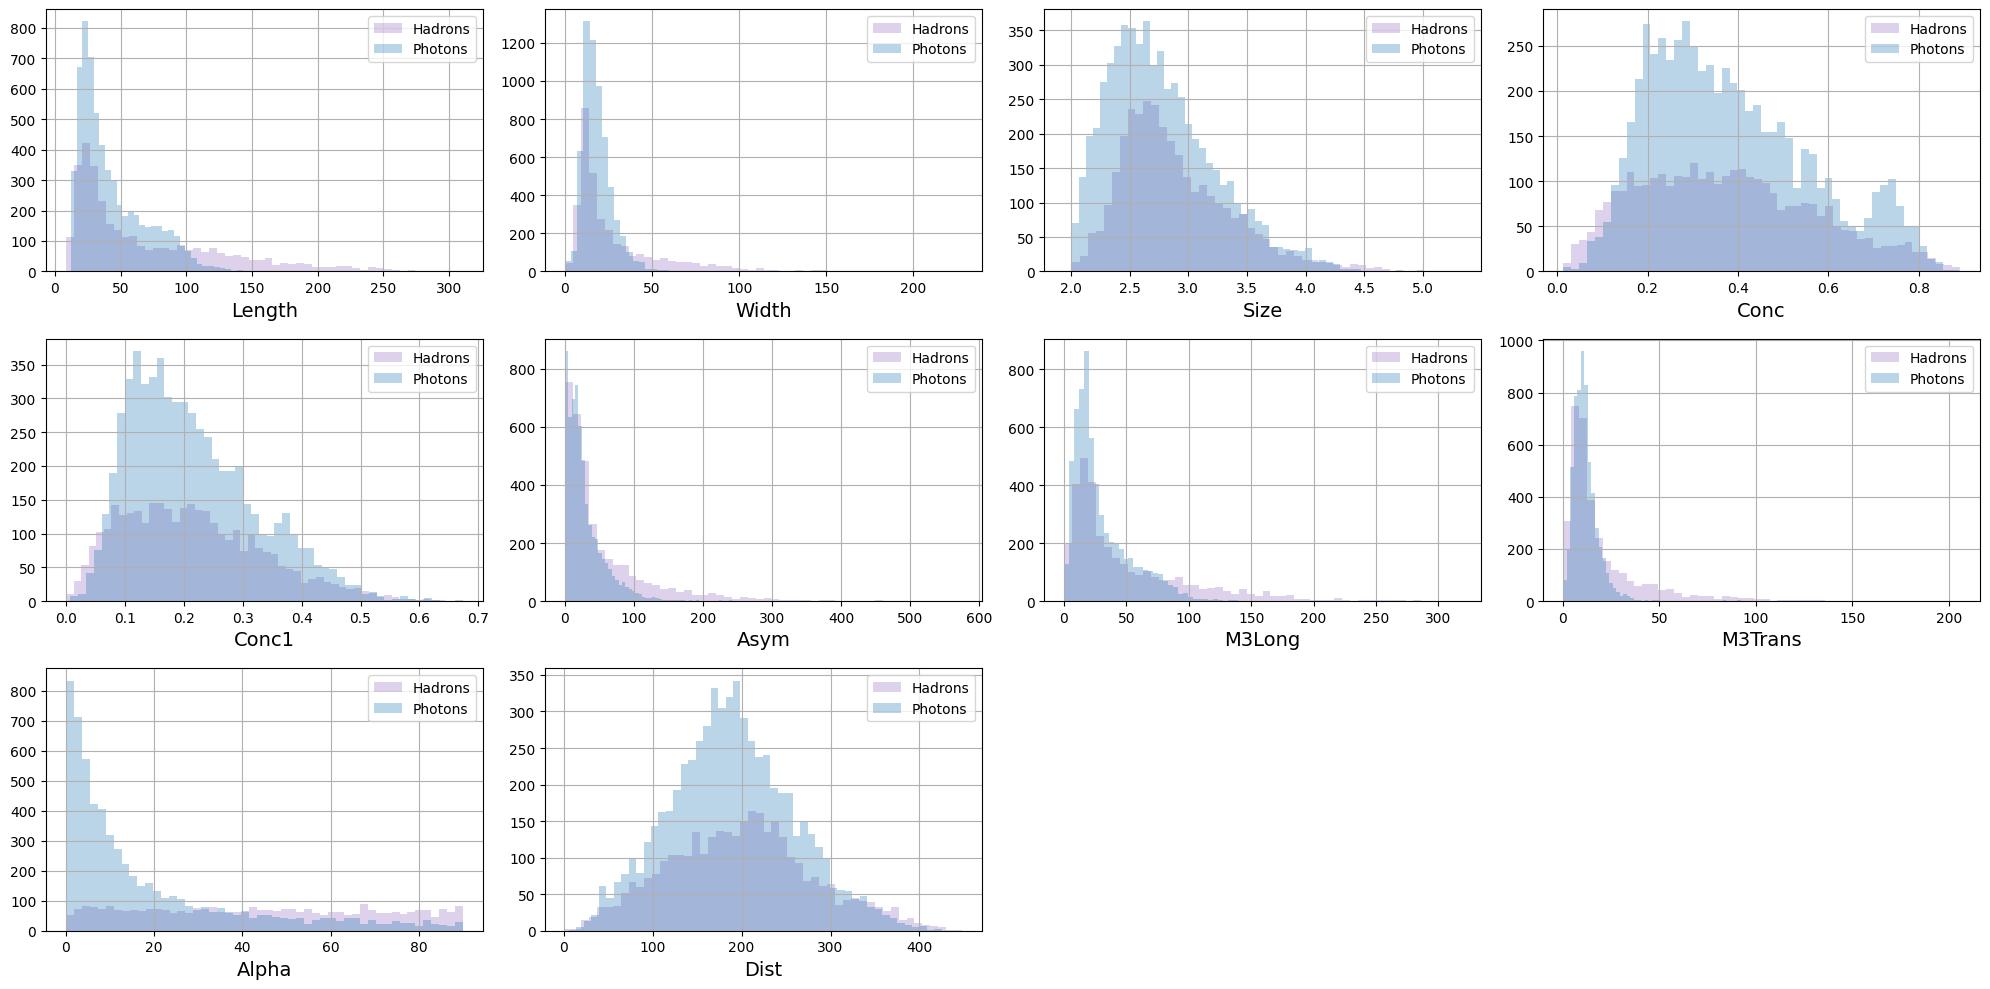

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0], X_train[y_train[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

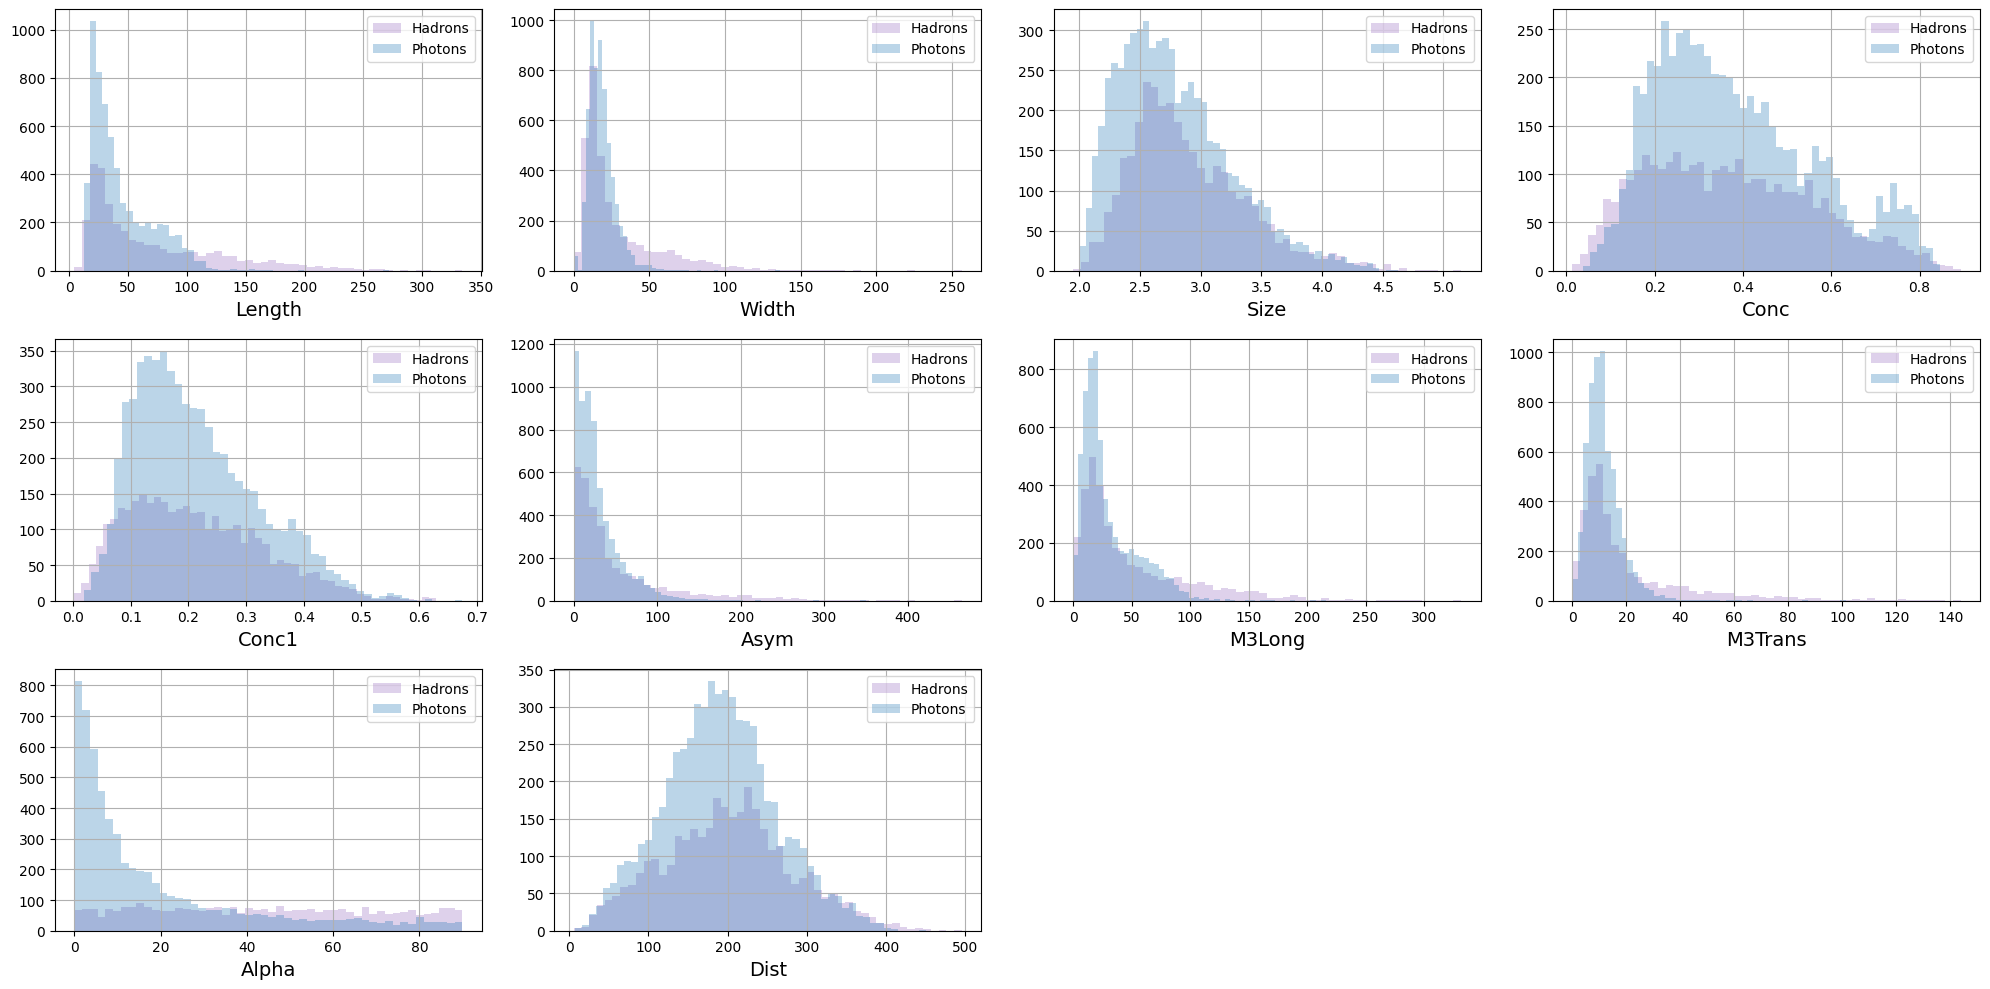

In [ ]:
plot_hists(
    X_test[y_test[:, 0] == 0], X_test[y_test[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

## Нормализуем

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным.

In [ ]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)

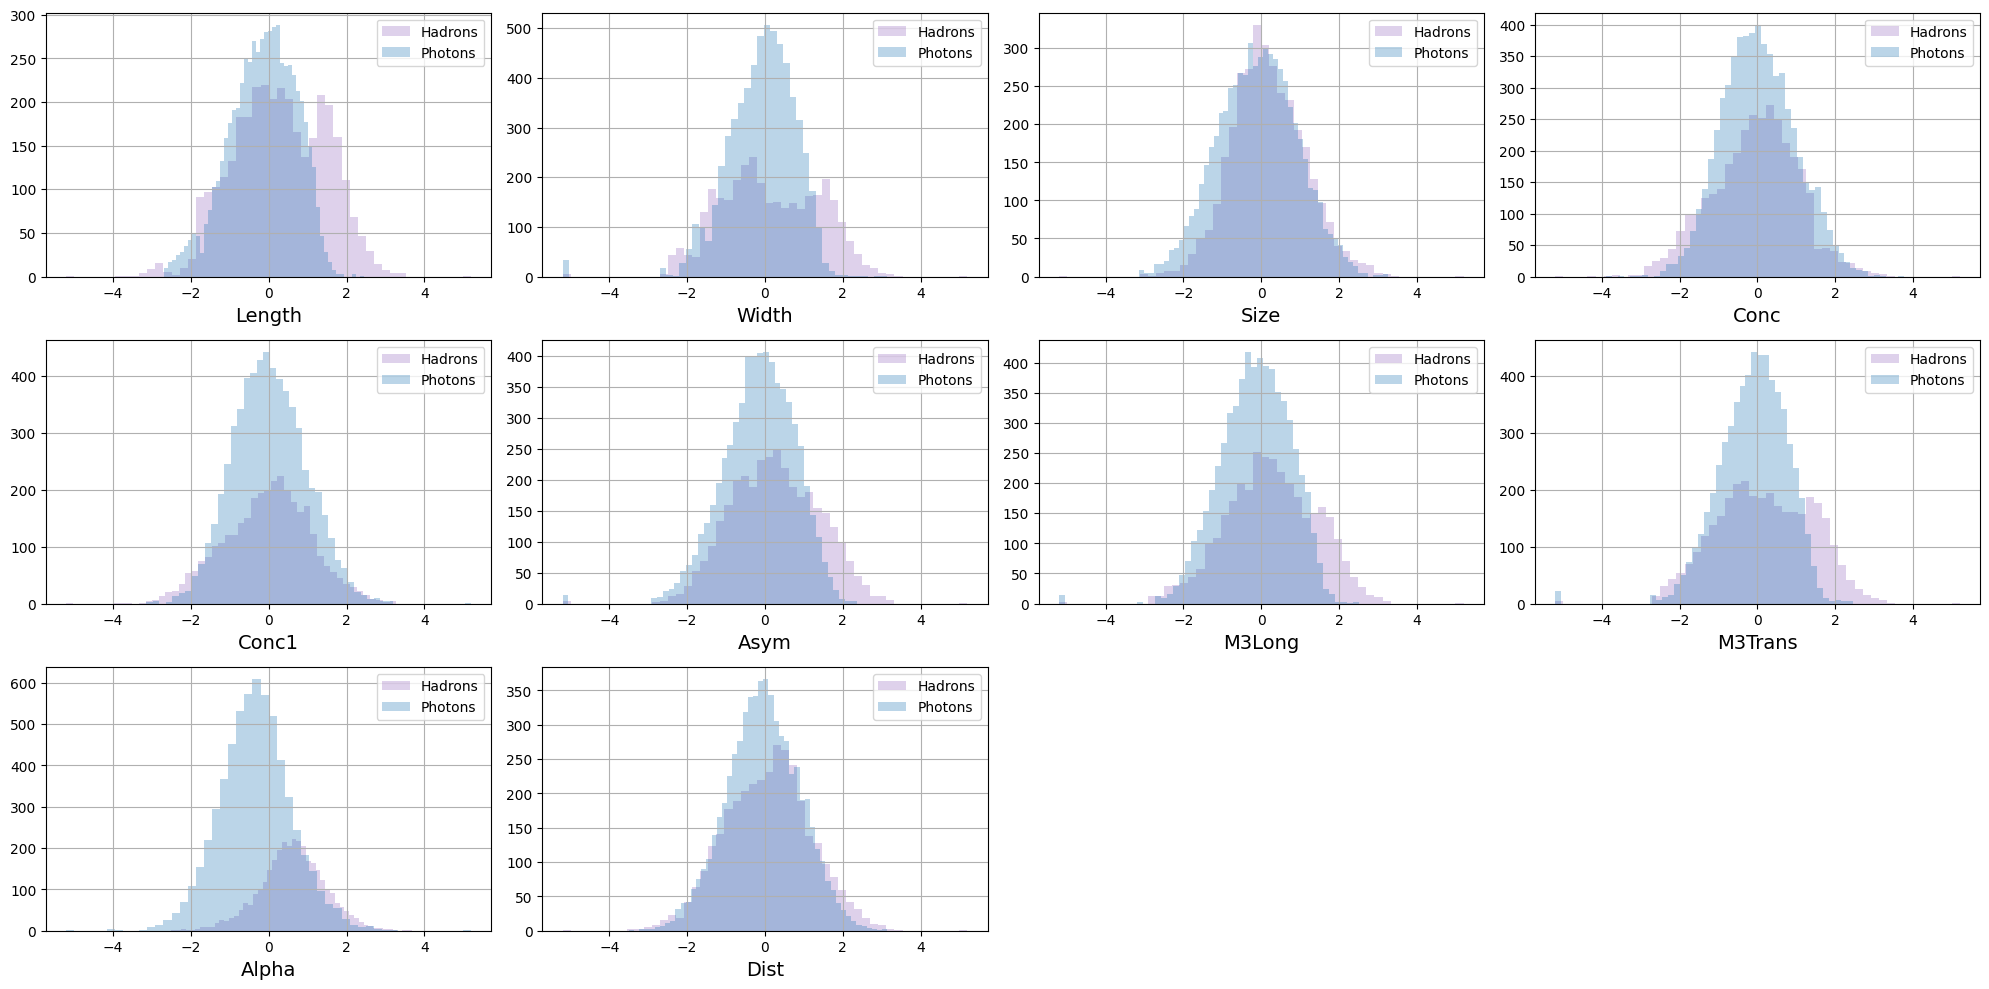

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

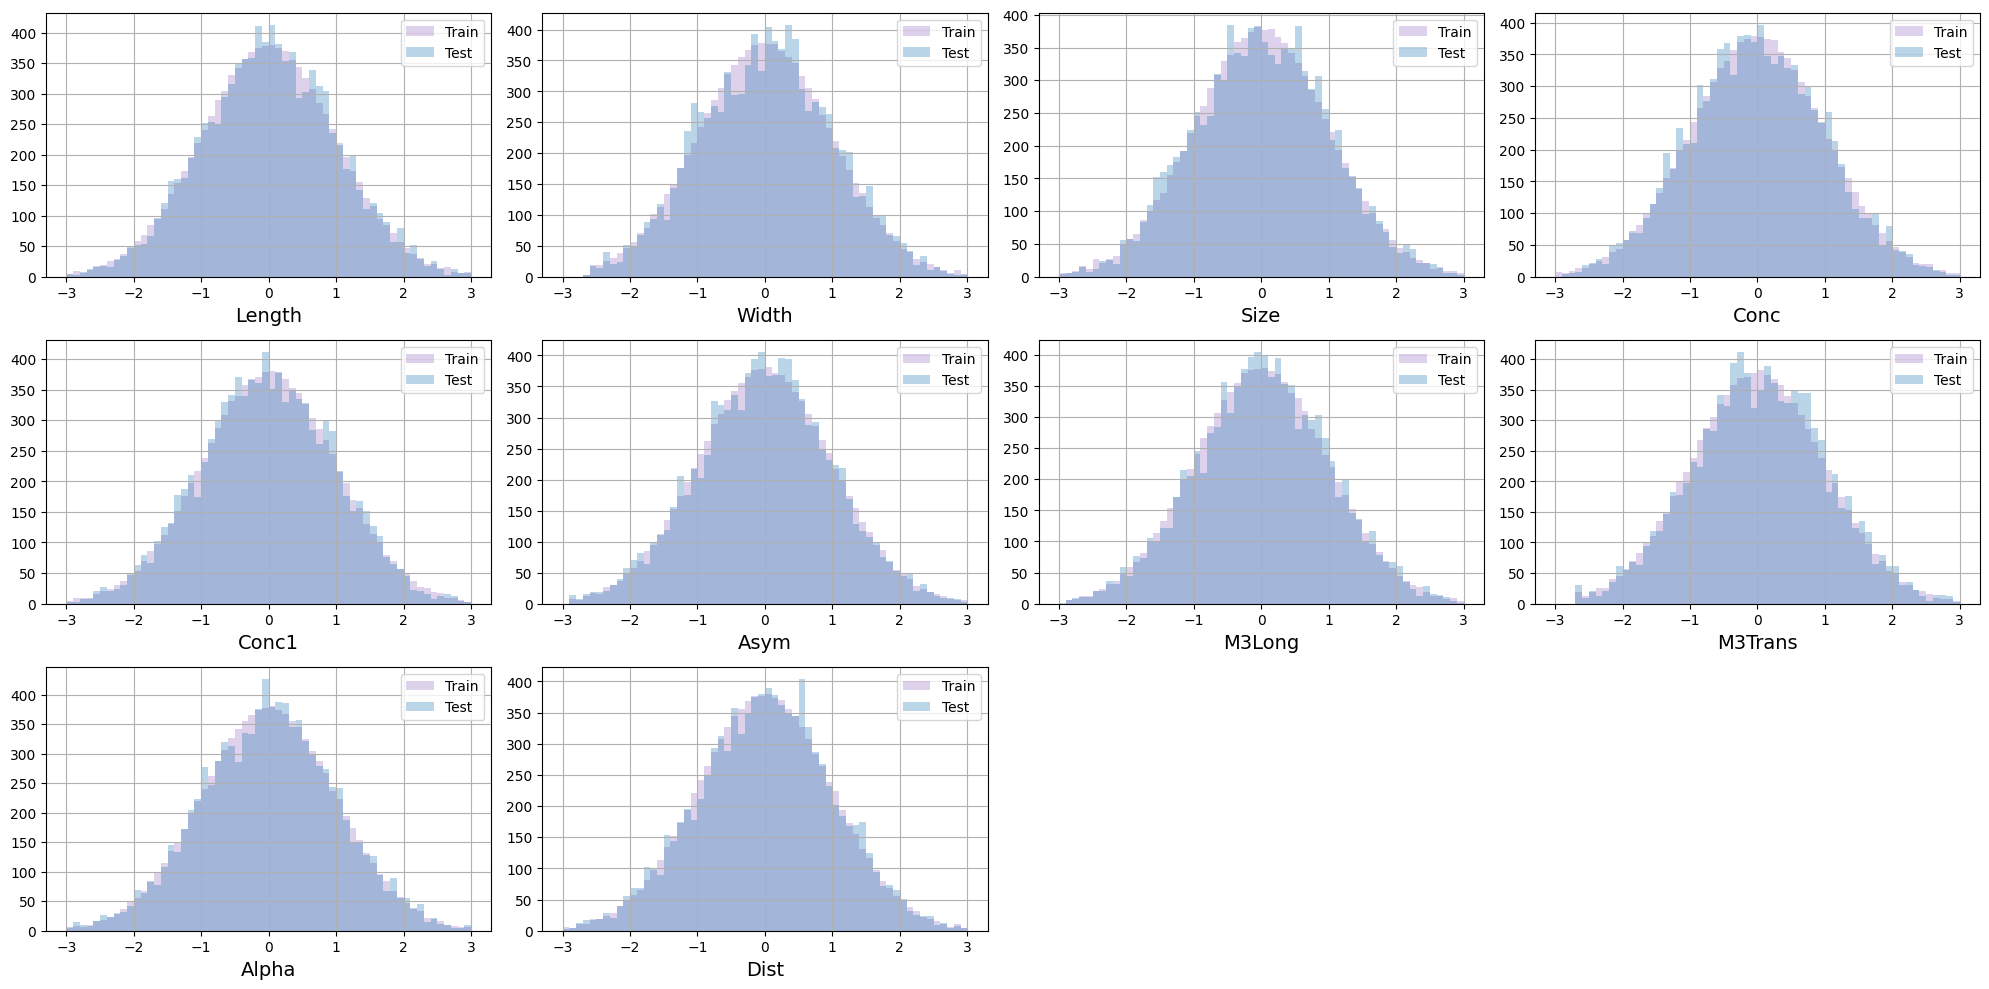

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cpu')

## Архитектура генератора

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.seq = nn.Sequential(
          nn.Linear(n_inputs, 100),
          nn.BatchNorm1d(100),
          nn.ReLU(),

          nn.Linear(100, 100),
          nn.BatchNorm1d(100),
          nn.ReLU(),

          nn.Linear(100, n_outputs),
          # nn.Tanh()
        )

    def forward(self, z, y):
        z = z.to(DEVICE)
        y = y.to(DEVICE)
        zy = torch.cat((z, y), dim=1)

        result = self.seq(zy)
        return result

## Функция для генерации новых объектов по y


In [ ]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    Z_noise = torch.normal(0, 1, (len(y), latent_dim)).to(DEVICE)
    generator.eval()
    y_tensor = torch.FloatTensor(y)

    with torch.no_grad():
        X_fake_tensor = generator(Z_noise, y_tensor)
    X_fake = X_fake_tensor.cpu().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Архитектура дискриминатора


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.layer1 = nn.Linear(n_inputs, 100)
        self.relu1 = nn.ReLU()

        self.layer2 = nn.Linear(100, 100)
        self.relu2 = nn.ReLU()

        self.output_layer = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        x = self.layer1(xy)
        x = self.relu1(x)

        x = self.layer2(x)
        x = self.relu2(x)

        x = self.output_layer(x)
        # x = self.sigmoid(x)
        return x

 Вообще, дискриминатор проще интерпретировать вероятностно, так что юзанем сигмойду

 опытным путем выяснил что без нее круче метрики, все таки не юзнем

## Внешняя оценка

Давайте создадим функцию, которая будет принимать на вход набор сгенерированных и настоящих объектов, затем выполнит следующие шаги:

	1.	Разделение данных:
	•	Функция будет разбивать входной набор на тренировочную и тестовую выборки в соотношении 3:1, при этом учитывая баланс классов (реальные и сгенерированные объекты).
	2.	Обучение моделей:
	•	В функции будут обучаться две модели: логистическая регрессия и градиентный бустинг. Обе модели будут тренироваться на задаче различения настоящих объектов от сгенерированных.
	3.	Оценка качества:
	•	После обучения функция будет вычислять и выводить значение accuracy на отложенной тестовой выборке для каждой модели.

Таким образом, функция позволит оценить, насколько хорошо обученные модели могут отличать настоящие объекты от фальшивых, предоставляя значения accuracy score для обеих моделей на тестовых данных.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):

    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, test_size=0.25, random_state=42)
    X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake, y_fake, test_size=0.25, random_state=42)

    # Собираем данные вместе
    X_train = np.concatenate((X_real_train, X_fake_train), axis=0)
    X_test = np.concatenate((X_real_test, X_fake_test), axis=0)
    y_train = np.concatenate((y_real_train, y_fake_train), axis=0)
    y_test = np.concatenate((y_real_test, y_fake_test), axis=0)

    log_reg_model = LogisticRegression()
    log_reg_model.fit(X_train, y_train)
    log_reg_score = accuracy_score(y_test, log_reg_model.predict(X_test))

    boosting_model = GradientBoostingClassifier()
    boosting_model.fit(X_train, y_train)
    boosting_score = accuracy_score(y_test, boosting_model.predict(X_test))



    print("Linear regression score: " + str(log_reg_score))
    print("Boosting score: " + str(boosting_score))

мы стараемся различать факе от ориджиналь

если аккураси будет 1, то значит идеально различает классификатор, значит генератор деградирует

если аккураси 0, то не различает, генератор перестарался

хотим что-то среднее - 0.5 - 0.6

## Обучение


In [ ]:
from tqdm import tqdm
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in tqdm(range(self.n_epochs)):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):


                # Train discriminator
                self.opt_disc.zero_grad()
                z = torch.normal(0, 1, (len(real_batch), self.latent_dim))
                z.to(DEVICE)
                fake_imgs = self.generator(z, cond_batch)

                real_d = self.discriminator(real_batch, cond_batch)
                fake_d = self.discriminator(fake_imgs, cond_batch)

                d_loss = -torch.mean(real_d) + torch.mean(fake_d)
                d_loss.backward()
                self.opt_disc.step()

                for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

                # Train generator
                self.opt_gen.zero_grad()
                if epoch % self.n_critic == 0:
                    z = torch.normal(0, 1, (len(real_batch), self.latent_dim))
                    z.to(DEVICE)
                    fake_imgs = self.generator(z, cond_batch)
                    fake_d = self.discriminator(fake_imgs, cond_batch)
                    g_loss = -torch.mean(fake_d)

                    g_loss.backward()
                    self.opt_gen.step()


            # caiculate and store loss after an epoch
            with torch.no_grad():
                Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
                X_fake = self.generator(Z_noise, y_cond)
                loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                    self.discriminator(X_fake, y_cond)
                )
                self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score


                X_real_sample = X_real[np.random.choice(len(X_train), size=1000, replace=False)]
                X_fake_sample = X_fake[np.random.choice(len(X_fake), size=1000, replace=False)]
                y_real_sample = torch.ones(1000, 1)
                y_fake_sample = torch.zeros(1000, 1)
                other_agent_score(X_real_sample, y_real_sample, X_fake_sample, y_fake_sample)


        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)


Обучим модель на данных.

In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=1,
)
fitter.fit(X_train, y_train)

  1%|          | 1/100 [00:04<07:11,  4.35s/it]

Linear regression score: 0.55
Boosting score: 0.806


  2%|▏         | 2/100 [00:06<05:16,  3.23s/it]

Linear regression score: 0.566
Boosting score: 0.778


  3%|▎         | 3/100 [00:08<04:04,  2.53s/it]

Linear regression score: 0.552
Boosting score: 0.686


  4%|▍         | 4/100 [00:10<03:34,  2.23s/it]

Linear regression score: 0.648
Boosting score: 0.72


  5%|▌         | 5/100 [00:11<03:11,  2.02s/it]

Linear regression score: 0.574
Boosting score: 0.686


  6%|▌         | 6/100 [00:13<02:57,  1.88s/it]

Linear regression score: 0.546
Boosting score: 0.646


  7%|▋         | 7/100 [00:15<03:05,  2.00s/it]

Linear regression score: 0.586
Boosting score: 0.632


  8%|▊         | 8/100 [00:17<02:57,  1.93s/it]

Linear regression score: 0.54
Boosting score: 0.674


  9%|▉         | 9/100 [00:19<02:47,  1.84s/it]

Linear regression score: 0.514
Boosting score: 0.654


 10%|█         | 10/100 [00:20<02:39,  1.77s/it]

Linear regression score: 0.574
Boosting score: 0.618


 11%|█         | 11/100 [00:22<02:34,  1.73s/it]

Linear regression score: 0.608
Boosting score: 0.7


 12%|█▏        | 12/100 [00:24<02:29,  1.70s/it]

Linear regression score: 0.69
Boosting score: 0.714


 13%|█▎        | 13/100 [00:25<02:25,  1.67s/it]

Linear regression score: 0.678
Boosting score: 0.662


 14%|█▍        | 14/100 [00:27<02:33,  1.79s/it]

Linear regression score: 0.568
Boosting score: 0.63


 15%|█▌        | 15/100 [00:29<02:36,  1.84s/it]

Linear regression score: 0.594
Boosting score: 0.626


 16%|█▌        | 16/100 [00:31<02:30,  1.79s/it]

Linear regression score: 0.598
Boosting score: 0.638


 17%|█▋        | 17/100 [00:33<02:26,  1.76s/it]

Linear regression score: 0.618
Boosting score: 0.644


 18%|█▊        | 18/100 [00:34<02:23,  1.75s/it]

Linear regression score: 0.57
Boosting score: 0.588


 19%|█▉        | 19/100 [00:36<02:18,  1.71s/it]

Linear regression score: 0.652
Boosting score: 0.662


 20%|██        | 20/100 [00:38<02:16,  1.71s/it]

Linear regression score: 0.606
Boosting score: 0.612


 21%|██        | 21/100 [00:40<02:24,  1.83s/it]

Linear regression score: 0.596
Boosting score: 0.6


 22%|██▏       | 22/100 [00:42<02:26,  1.88s/it]

Linear regression score: 0.71
Boosting score: 0.646


 23%|██▎       | 23/100 [00:43<02:20,  1.82s/it]

Linear regression score: 0.652
Boosting score: 0.688


 24%|██▍       | 24/100 [00:45<02:13,  1.76s/it]

Linear regression score: 0.626
Boosting score: 0.632


 25%|██▌       | 25/100 [00:47<02:08,  1.72s/it]

Linear regression score: 0.566
Boosting score: 0.602


 26%|██▌       | 26/100 [00:48<02:04,  1.69s/it]

Linear regression score: 0.592
Boosting score: 0.648


 27%|██▋       | 27/100 [00:50<02:01,  1.67s/it]

Linear regression score: 0.714
Boosting score: 0.662


 28%|██▊       | 28/100 [00:53<02:25,  2.02s/it]

Linear regression score: 0.614
Boosting score: 0.612


 29%|██▉       | 29/100 [00:56<02:48,  2.37s/it]

Linear regression score: 0.674
Boosting score: 0.646


 30%|███       | 30/100 [01:01<03:33,  3.04s/it]

Linear regression score: 0.564
Boosting score: 0.632


 31%|███       | 31/100 [01:03<03:09,  2.74s/it]

Linear regression score: 0.578
Boosting score: 0.596


 32%|███▏      | 32/100 [01:04<02:49,  2.49s/it]

Linear regression score: 0.568
Boosting score: 0.622


 33%|███▎      | 33/100 [01:07<02:42,  2.43s/it]

Linear regression score: 0.632
Boosting score: 0.622


 34%|███▍      | 34/100 [01:08<02:26,  2.22s/it]

Linear regression score: 0.61
Boosting score: 0.628


 35%|███▌      | 35/100 [01:10<02:14,  2.06s/it]

Linear regression score: 0.572
Boosting score: 0.652


 36%|███▌      | 36/100 [01:12<02:04,  1.95s/it]

Linear regression score: 0.618
Boosting score: 0.648


 37%|███▋      | 37/100 [01:14<01:57,  1.87s/it]

Linear regression score: 0.61
Boosting score: 0.624


 38%|███▊      | 38/100 [01:15<01:52,  1.82s/it]

Linear regression score: 0.684
Boosting score: 0.744


 39%|███▉      | 39/100 [01:17<01:55,  1.89s/it]

Linear regression score: 0.576
Boosting score: 0.602


 40%|████      | 40/100 [01:19<01:56,  1.95s/it]

Linear regression score: 0.638
Boosting score: 0.66


 41%|████      | 41/100 [01:21<01:51,  1.88s/it]

Linear regression score: 0.652
Boosting score: 0.71


 42%|████▏     | 42/100 [01:23<01:46,  1.84s/it]

Linear regression score: 0.51
Boosting score: 0.602


 43%|████▎     | 43/100 [01:25<01:42,  1.80s/it]

Linear regression score: 0.624
Boosting score: 0.624


 44%|████▍     | 44/100 [01:26<01:39,  1.78s/it]

Linear regression score: 0.586
Boosting score: 0.628


 45%|████▌     | 45/100 [01:28<01:36,  1.75s/it]

Linear regression score: 0.65
Boosting score: 0.652


 46%|████▌     | 46/100 [01:30<01:42,  1.90s/it]

Linear regression score: 0.664
Boosting score: 0.618


 47%|████▋     | 47/100 [01:32<01:41,  1.91s/it]

Linear regression score: 0.51
Boosting score: 0.57


 48%|████▊     | 48/100 [01:34<01:36,  1.86s/it]

Linear regression score: 0.614
Boosting score: 0.604


 49%|████▉     | 49/100 [01:36<01:32,  1.81s/it]

Linear regression score: 0.5
Boosting score: 0.59


 50%|█████     | 50/100 [01:37<01:28,  1.77s/it]

Linear regression score: 0.626
Boosting score: 0.644


 51%|█████     | 51/100 [01:39<01:25,  1.74s/it]

Linear regression score: 0.612
Boosting score: 0.682


 52%|█████▏    | 52/100 [01:41<01:24,  1.76s/it]

Linear regression score: 0.572
Boosting score: 0.61


 53%|█████▎    | 53/100 [01:43<01:32,  1.96s/it]

Linear regression score: 0.584
Boosting score: 0.63


 54%|█████▍    | 54/100 [01:45<01:26,  1.88s/it]

Linear regression score: 0.584
Boosting score: 0.608


 55%|█████▌    | 55/100 [01:47<01:22,  1.83s/it]

Linear regression score: 0.582
Boosting score: 0.664


 56%|█████▌    | 56/100 [01:48<01:19,  1.82s/it]

Linear regression score: 0.602
Boosting score: 0.66


 57%|█████▋    | 57/100 [01:50<01:17,  1.80s/it]

Linear regression score: 0.586
Boosting score: 0.62


 58%|█████▊    | 58/100 [01:52<01:14,  1.78s/it]

Linear regression score: 0.56
Boosting score: 0.63


 59%|█████▉    | 59/100 [01:54<01:15,  1.85s/it]

Linear regression score: 0.654
Boosting score: 0.656


 60%|██████    | 60/100 [01:56<01:19,  2.00s/it]

Linear regression score: 0.552
Boosting score: 0.63


 61%|██████    | 61/100 [01:58<01:15,  1.93s/it]

Linear regression score: 0.626
Boosting score: 0.69


 62%|██████▏   | 62/100 [02:00<01:10,  1.87s/it]

Linear regression score: 0.584
Boosting score: 0.608


 63%|██████▎   | 63/100 [02:01<01:07,  1.81s/it]

Linear regression score: 0.69
Boosting score: 0.678


 64%|██████▍   | 64/100 [02:03<01:04,  1.79s/it]

Linear regression score: 0.516
Boosting score: 0.586


 65%|██████▌   | 65/100 [02:05<01:01,  1.77s/it]

Linear regression score: 0.61
Boosting score: 0.658


 66%|██████▌   | 66/100 [02:07<01:03,  1.86s/it]

Linear regression score: 0.634
Boosting score: 0.662


 67%|██████▋   | 67/100 [02:09<01:04,  1.96s/it]

Linear regression score: 0.554
Boosting score: 0.63


 68%|██████▊   | 68/100 [02:11<01:00,  1.90s/it]

Linear regression score: 0.582
Boosting score: 0.648


 69%|██████▉   | 69/100 [02:13<00:57,  1.87s/it]

Linear regression score: 0.622
Boosting score: 0.612


 70%|███████   | 70/100 [02:15<00:55,  1.86s/it]

Linear regression score: 0.694
Boosting score: 0.66


 71%|███████   | 71/100 [02:16<00:54,  1.86s/it]

Linear regression score: 0.556
Boosting score: 0.588


 72%|███████▏  | 72/100 [02:18<00:51,  1.85s/it]

Linear regression score: 0.632
Boosting score: 0.602


 73%|███████▎  | 73/100 [02:21<00:54,  2.03s/it]

Linear regression score: 0.502
Boosting score: 0.606


 74%|███████▍  | 74/100 [02:22<00:50,  1.95s/it]

Linear regression score: 0.666
Boosting score: 0.644


 75%|███████▌  | 75/100 [02:24<00:47,  1.89s/it]

Linear regression score: 0.67
Boosting score: 0.632


 76%|███████▌  | 76/100 [02:26<00:45,  1.88s/it]

Linear regression score: 0.622
Boosting score: 0.642


 77%|███████▋  | 77/100 [02:28<00:42,  1.87s/it]

Linear regression score: 0.502
Boosting score: 0.636


 78%|███████▊  | 78/100 [02:30<00:40,  1.83s/it]

Linear regression score: 0.622
Boosting score: 0.62


 79%|███████▉  | 79/100 [02:32<00:39,  1.90s/it]

Linear regression score: 0.6
Boosting score: 0.62


 80%|████████  | 80/100 [02:34<00:39,  1.98s/it]

Linear regression score: 0.582
Boosting score: 0.604


 81%|████████  | 81/100 [02:36<00:36,  1.91s/it]

Linear regression score: 0.598
Boosting score: 0.63


 82%|████████▏ | 82/100 [02:37<00:33,  1.88s/it]

Linear regression score: 0.62
Boosting score: 0.628


 83%|████████▎ | 83/100 [02:39<00:32,  1.90s/it]

Linear regression score: 0.664
Boosting score: 0.632


 84%|████████▍ | 84/100 [02:41<00:30,  1.88s/it]

Linear regression score: 0.614
Boosting score: 0.654


 85%|████████▌ | 85/100 [02:43<00:28,  1.91s/it]

Linear regression score: 0.588
Boosting score: 0.608


 86%|████████▌ | 86/100 [02:46<00:29,  2.08s/it]

Linear regression score: 0.616
Boosting score: 0.642


 87%|████████▋ | 87/100 [02:47<00:25,  1.99s/it]

Linear regression score: 0.53
Boosting score: 0.56


 88%|████████▊ | 88/100 [02:49<00:23,  1.95s/it]

Linear regression score: 0.526
Boosting score: 0.596


 89%|████████▉ | 89/100 [02:51<00:20,  1.89s/it]

Linear regression score: 0.586
Boosting score: 0.582


 90%|█████████ | 90/100 [02:53<00:18,  1.85s/it]

Linear regression score: 0.626
Boosting score: 0.632


 91%|█████████ | 91/100 [02:55<00:16,  1.84s/it]

Linear regression score: 0.55
Boosting score: 0.616


 92%|█████████▏| 92/100 [02:57<00:15,  1.98s/it]

Linear regression score: 0.568
Boosting score: 0.606


 93%|█████████▎| 93/100 [02:59<00:13,  1.99s/it]

Linear regression score: 0.596
Boosting score: 0.608


 94%|█████████▍| 94/100 [03:01<00:11,  1.93s/it]

Linear regression score: 0.648
Boosting score: 0.606


 95%|█████████▌| 95/100 [03:02<00:09,  1.89s/it]

Linear regression score: 0.586
Boosting score: 0.594


 96%|█████████▌| 96/100 [03:04<00:07,  1.86s/it]

Linear regression score: 0.532
Boosting score: 0.584


 97%|█████████▋| 97/100 [03:06<00:05,  1.83s/it]

Linear regression score: 0.586
Boosting score: 0.618


 98%|█████████▊| 98/100 [03:08<00:03,  1.85s/it]

Linear regression score: 0.534
Boosting score: 0.646


 99%|█████████▉| 99/100 [03:10<00:02,  2.02s/it]

Linear regression score: 0.55
Boosting score: 0.592


100%|██████████| 100/100 [03:12<00:00,  1.93s/it]

Linear regression score: 0.64
Boosting score: 0.686
CPU times: user 3min 5s, sys: 11.1 s, total: 3min 16s
Wall time: 3min 12s


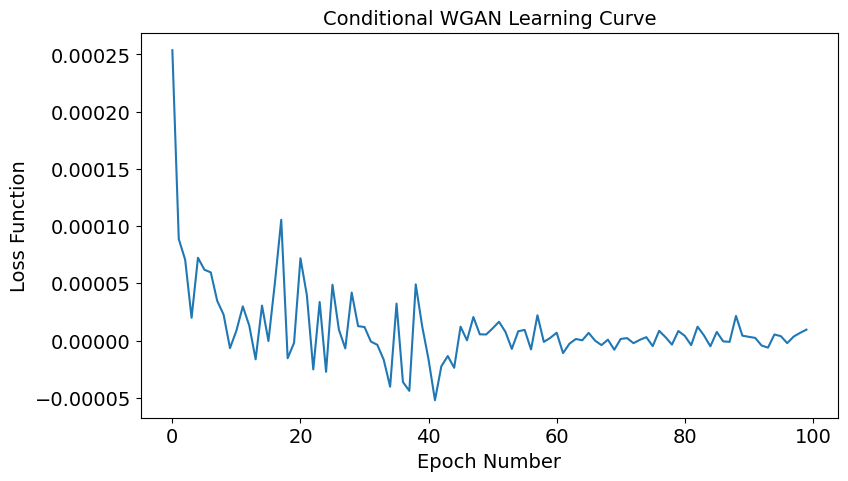

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
# plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Посмотрим как работает

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:

X_train_inv = quantile_transformer.inverse_transform(X_train)
X_test_inv = quantile_transformer.inverse_transform(X_test)


In [ ]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = quantile_transformer.inverse_transform(X_fake_train)

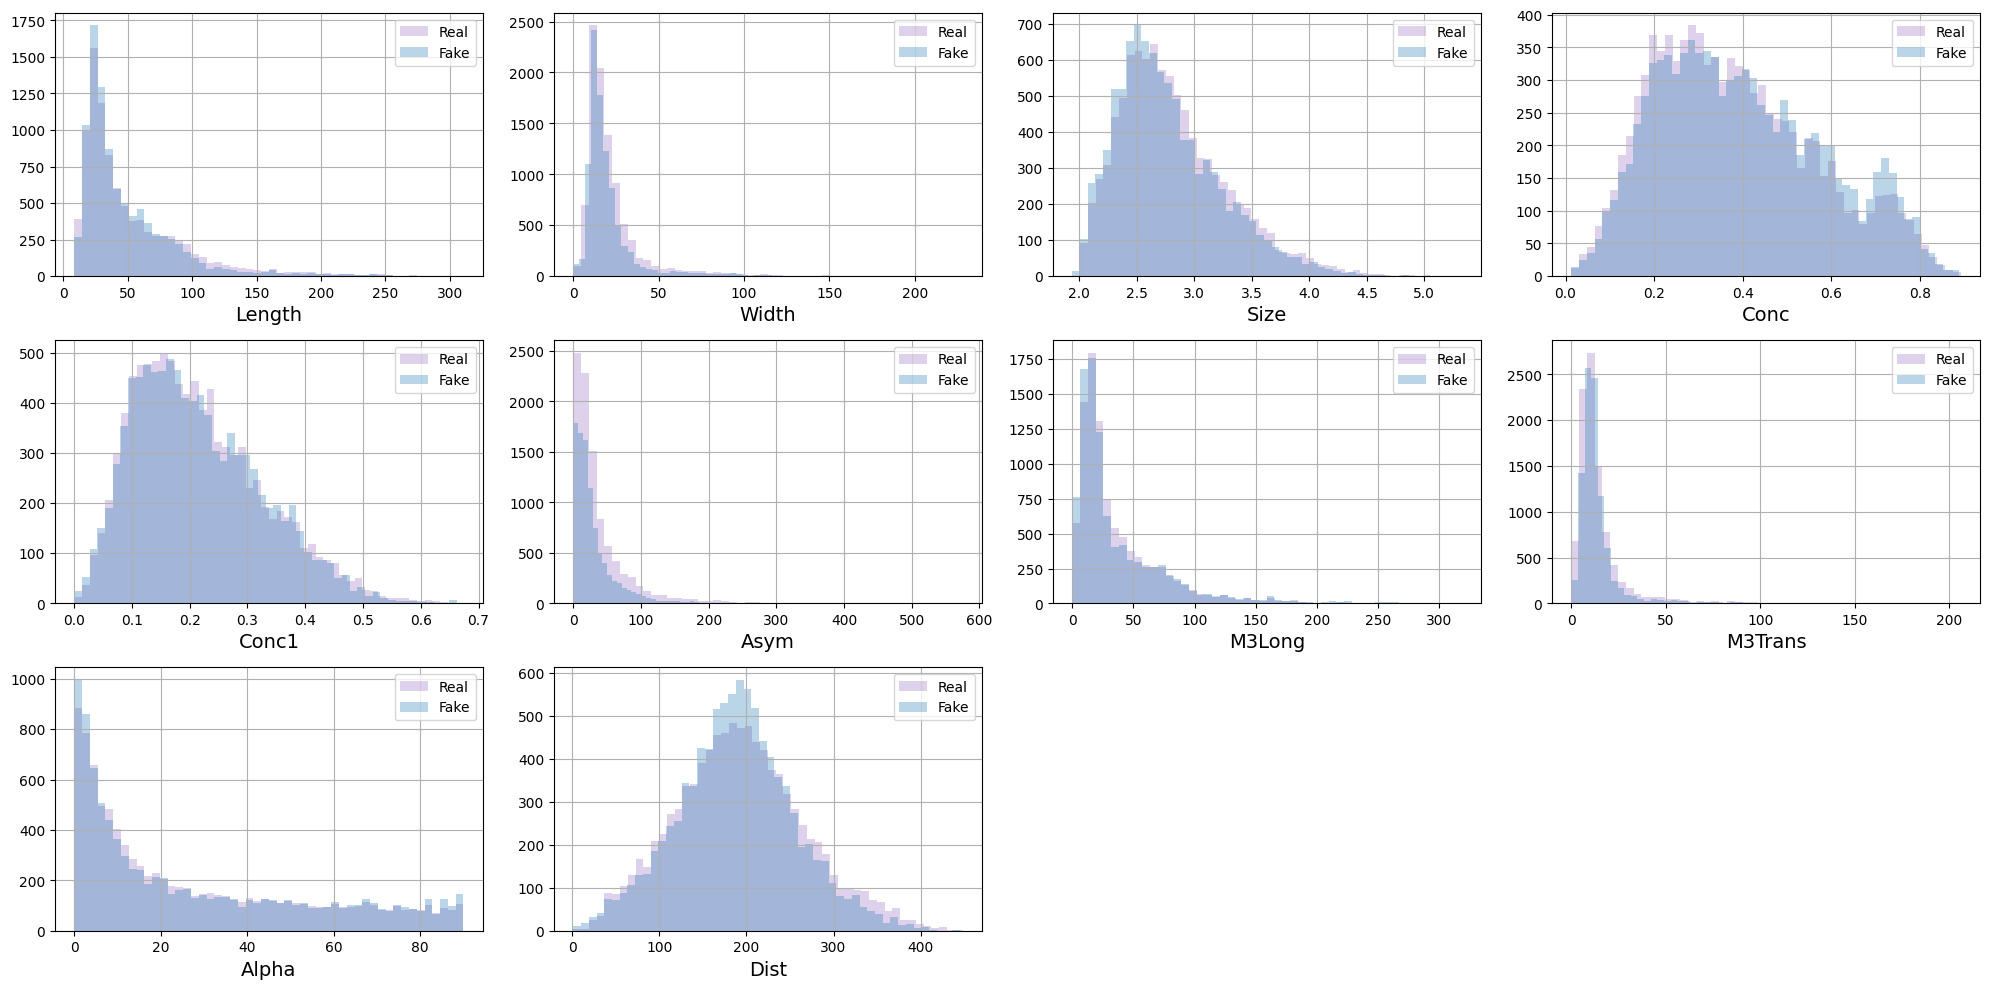

In [ ]:
plot_hists(X_train_inv, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = quantile_transformer.inverse_transform(X_fake_test)

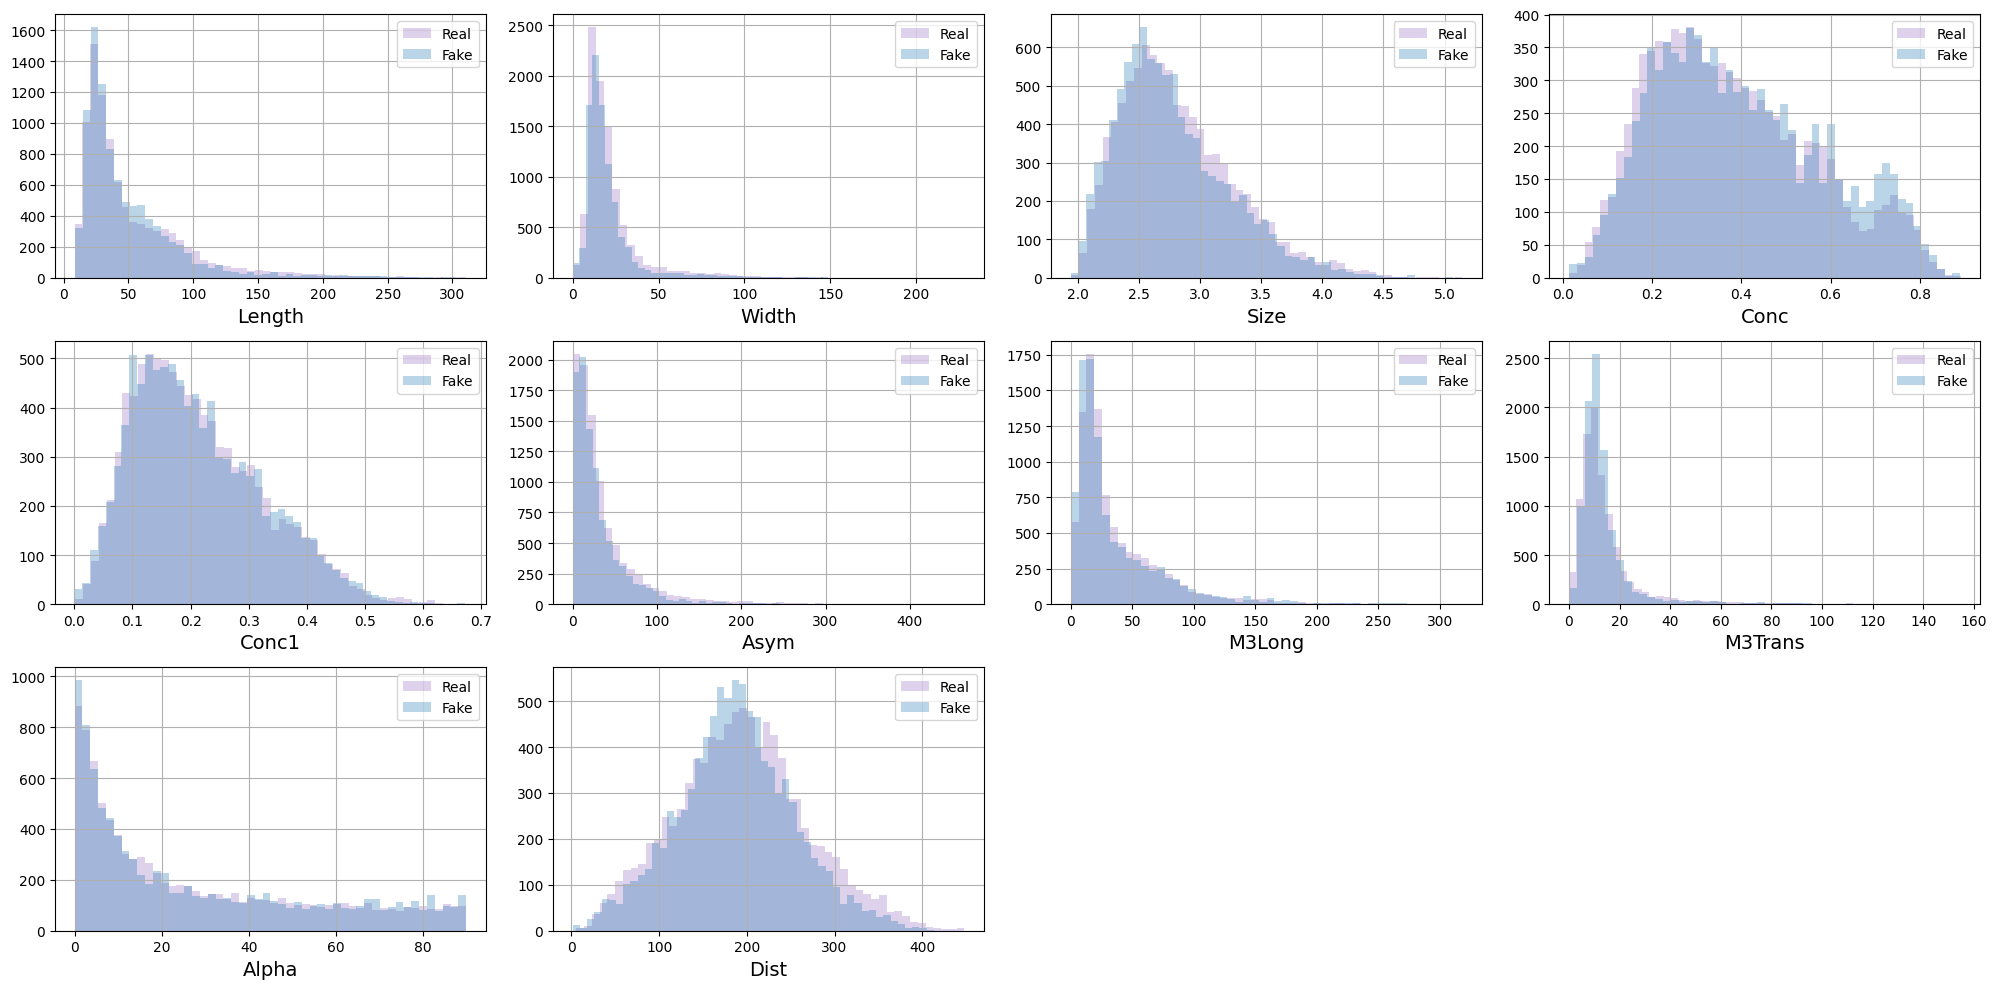

In [ ]:
plot_hists(X_test_inv, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_inv))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8014423137524171


## Итого

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?

Получились классные сгенерированные данные

ROCAUC для случайного классификатора = 0.5

Если будет слишком близко к 1, значит хорошо различает фейки - плохая генерация. Хочется низкий ROCAUC тогда, учитывая, что это не случайный классифаер, ниже 0.5 врядли получится, так что в районе 0.5-0.7 как будто было бы круто

у нас чуть больше, но генерация на первый взгляд нормас

Качели небольшие на кривой обучения, попробую с гиперпараметрами шаманить

ROCAUC с сигмойдой с n_critic = 5 - 0.95, n_critic = 1 - 0.77

без сигмойды n_critic = 5 - 0.98, n_critic = 1 - 0.74




## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Функция для зашумления

In [ ]:
def corrupt(x, amount):

    amount = amount.view(-1, 1)
    noise = torch.rand_like(x)
    x =  x * (1 - amount) + noise * amount

    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [ ]:
!pip install diffusers

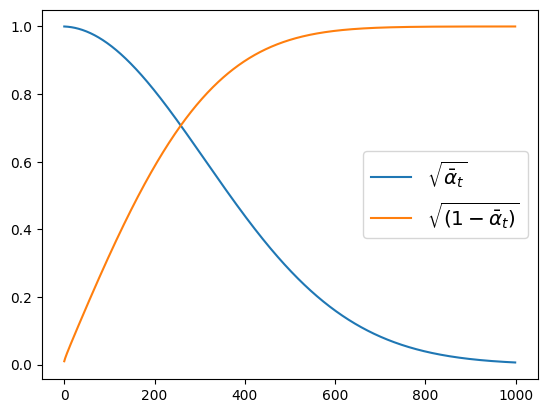

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Архитектура генератора

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.fc1 = nn.Linear(n_inputs, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100, n_outputs)
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        x = self.relu1(self.bn1(self.fc1(zy)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

## Функция генерации

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, scheduler = None):
    n_steps = 100  # =1 для other_agent_score, не влияет на обучение, очень замедляет
    z = torch.randn(len(y), latent_dim)
    y_tensor = torch.FloatTensor(y)
    model.eval()
    for i in range(n_steps):
      with torch.no_grad():
          pred = model(z, y_tensor)
          mix_factor = 1 / (n_steps - i)
          z = z * (1 - mix_factor) + pred * mix_factor
          # scheduler.step()
    X_fake_tensor = z
    return X_fake_tensor.cpu().numpy()


## Обучаем


In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        for epoch in tqdm(range(self.n_epochs)):
            loss_epoch = 0
            for i, (x, y_) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):


                # Generate random noise
                noise_amount = torch.rand(x.shape[0]).to(DEVICE)
                # noise = torch.randn_like(x)
                # timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(DEVICE)
                # noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
                noisy_x = corrupt(x, noise_amount)

                X_fake = self.model(noisy_x, y_)
                loss = F.mse_loss(X_fake, noisy_x)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()


            # calculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score


            X_fake = generate_with_diffusion(self.model, y_cond, latent_dim = 10)
            X_real_sample = X_real[np.random.choice(len(X_train), size=1000, replace=False)]
            X_fake_sample = X_fake[np.random.choice(len(X_fake), size=1000, replace=False)]
            y_real_sample = torch.ones(1000, 1)
            y_fake_sample = torch.zeros(1000, 1)
            other_agent_score(X_real_sample, y_real_sample, X_fake_sample, y_fake_sample)


        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001
)
diffusionFitter.fit(X_train, y_train)

  1%|          | 1/100 [00:01<02:00,  1.21s/it]

Linear regression score: 0.658
Boosting score: 0.85


  2%|▏         | 2/100 [00:02<02:20,  1.44s/it]

Linear regression score: 0.626
Boosting score: 0.86


  3%|▎         | 3/100 [00:04<02:10,  1.34s/it]

Linear regression score: 0.616
Boosting score: 0.914


  4%|▍         | 4/100 [00:05<01:58,  1.23s/it]

Linear regression score: 0.596
Boosting score: 0.91


  5%|▌         | 5/100 [00:06<01:51,  1.17s/it]

Linear regression score: 0.548
Boosting score: 0.908


  6%|▌         | 6/100 [00:07<01:46,  1.13s/it]

Linear regression score: 0.578
Boosting score: 0.906


  7%|▋         | 7/100 [00:08<01:43,  1.11s/it]

Linear regression score: 0.592
Boosting score: 0.902


  8%|▊         | 8/100 [00:09<01:40,  1.10s/it]

Linear regression score: 0.572
Boosting score: 0.894


  9%|▉         | 9/100 [00:10<01:39,  1.09s/it]

Linear regression score: 0.574
Boosting score: 0.918


 10%|█         | 10/100 [00:11<01:37,  1.08s/it]

Linear regression score: 0.586
Boosting score: 0.936


 11%|█         | 11/100 [00:12<01:35,  1.08s/it]

Linear regression score: 0.542
Boosting score: 0.92


 12%|█▏        | 12/100 [00:13<01:38,  1.12s/it]

Linear regression score: 0.588
Boosting score: 0.91


 13%|█▎        | 13/100 [00:15<01:48,  1.25s/it]

Linear regression score: 0.502
Boosting score: 0.906


 14%|█▍        | 14/100 [00:16<01:46,  1.24s/it]

Linear regression score: 0.544
Boosting score: 0.924


 15%|█▌        | 15/100 [00:17<01:40,  1.18s/it]

Linear regression score: 0.534
Boosting score: 0.934


 16%|█▌        | 16/100 [00:18<01:36,  1.14s/it]

Linear regression score: 0.534
Boosting score: 0.896


 17%|█▋        | 17/100 [00:19<01:33,  1.12s/it]

Linear regression score: 0.536
Boosting score: 0.924


 18%|█▊        | 18/100 [00:20<01:30,  1.10s/it]

Linear regression score: 0.6
Boosting score: 0.908


 19%|█▉        | 19/100 [00:21<01:28,  1.09s/it]

Linear regression score: 0.556
Boosting score: 0.89


 20%|██        | 20/100 [00:22<01:26,  1.09s/it]

Linear regression score: 0.546
Boosting score: 0.9


 21%|██        | 21/100 [00:23<01:25,  1.09s/it]

Linear regression score: 0.57
Boosting score: 0.896


 22%|██▏       | 22/100 [00:25<01:24,  1.09s/it]

Linear regression score: 0.55
Boosting score: 0.912


 23%|██▎       | 23/100 [00:26<01:27,  1.14s/it]

Linear regression score: 0.504
Boosting score: 0.906


 24%|██▍       | 24/100 [00:27<01:36,  1.26s/it]

Linear regression score: 0.534
Boosting score: 0.88


 25%|██▌       | 25/100 [00:29<01:44,  1.40s/it]

Linear regression score: 0.528
Boosting score: 0.93


 26%|██▌       | 26/100 [00:30<01:38,  1.33s/it]

Linear regression score: 0.55
Boosting score: 0.928


 27%|██▋       | 27/100 [00:31<01:31,  1.25s/it]

Linear regression score: 0.554
Boosting score: 0.92


 28%|██▊       | 28/100 [00:32<01:25,  1.19s/it]

Linear regression score: 0.59
Boosting score: 0.914


 29%|██▉       | 29/100 [00:33<01:21,  1.14s/it]

Linear regression score: 0.54
Boosting score: 0.912


 30%|███       | 30/100 [00:34<01:18,  1.12s/it]

Linear regression score: 0.574
Boosting score: 0.918


 31%|███       | 31/100 [00:36<01:15,  1.10s/it]

Linear regression score: 0.572
Boosting score: 0.922


 32%|███▏      | 32/100 [00:37<01:13,  1.09s/it]

Linear regression score: 0.538
Boosting score: 0.928


 33%|███▎      | 33/100 [00:38<01:12,  1.08s/it]

Linear regression score: 0.542
Boosting score: 0.926


 34%|███▍      | 34/100 [00:39<01:20,  1.22s/it]

Linear regression score: 0.576
Boosting score: 0.93


 35%|███▌      | 35/100 [00:41<01:21,  1.25s/it]

Linear regression score: 0.556
Boosting score: 0.888


 36%|███▌      | 36/100 [00:42<01:16,  1.20s/it]

Linear regression score: 0.544
Boosting score: 0.938


 37%|███▋      | 37/100 [00:43<01:12,  1.15s/it]

Linear regression score: 0.53
Boosting score: 0.912


 38%|███▊      | 38/100 [00:44<01:09,  1.13s/it]

Linear regression score: 0.524
Boosting score: 0.924


 39%|███▉      | 39/100 [00:45<01:07,  1.11s/it]

Linear regression score: 0.594
Boosting score: 0.936


 40%|████      | 40/100 [00:46<01:05,  1.10s/it]

Linear regression score: 0.598
Boosting score: 0.906


 41%|████      | 41/100 [00:47<01:04,  1.09s/it]

Linear regression score: 0.544
Boosting score: 0.928


 42%|████▏     | 42/100 [00:48<01:02,  1.08s/it]

Linear regression score: 0.512
Boosting score: 0.92


 43%|████▎     | 43/100 [00:49<01:02,  1.09s/it]

Linear regression score: 0.57
Boosting score: 0.912


 44%|████▍     | 44/100 [00:50<01:02,  1.12s/it]

Linear regression score: 0.502
Boosting score: 0.9


 45%|████▌     | 45/100 [00:52<01:08,  1.24s/it]

Linear regression score: 0.496
Boosting score: 0.936


 46%|████▌     | 46/100 [00:53<01:08,  1.26s/it]

Linear regression score: 0.544
Boosting score: 0.946


 47%|████▋     | 47/100 [00:54<01:03,  1.20s/it]

Linear regression score: 0.532
Boosting score: 0.894


 48%|████▊     | 48/100 [00:55<01:00,  1.16s/it]

Linear regression score: 0.512
Boosting score: 0.908


 49%|████▉     | 49/100 [00:56<00:57,  1.13s/it]

Linear regression score: 0.55
Boosting score: 0.92


 50%|█████     | 50/100 [00:57<00:55,  1.11s/it]

Linear regression score: 0.566
Boosting score: 0.926


 51%|█████     | 51/100 [00:59<00:54,  1.11s/it]

Linear regression score: 0.574
Boosting score: 0.912


 52%|█████▏    | 52/100 [01:00<00:52,  1.09s/it]

Linear regression score: 0.538
Boosting score: 0.92


 53%|█████▎    | 53/100 [01:01<00:50,  1.08s/it]

Linear regression score: 0.508
Boosting score: 0.934


 54%|█████▍    | 54/100 [01:02<00:49,  1.07s/it]

Linear regression score: 0.49
Boosting score: 0.926


 55%|█████▌    | 55/100 [01:03<00:49,  1.10s/it]

Linear regression score: 0.536
Boosting score: 0.918


 56%|█████▌    | 56/100 [01:04<00:53,  1.23s/it]

Linear regression score: 0.496
Boosting score: 0.908


 57%|█████▋    | 57/100 [01:06<00:53,  1.24s/it]

Linear regression score: 0.512
Boosting score: 0.924


 58%|█████▊    | 58/100 [01:07<00:49,  1.19s/it]

Linear regression score: 0.54
Boosting score: 0.922


 59%|█████▉    | 59/100 [01:08<00:47,  1.16s/it]

Linear regression score: 0.59
Boosting score: 0.926


 60%|██████    | 60/100 [01:09<00:45,  1.14s/it]

Linear regression score: 0.54
Boosting score: 0.934


 61%|██████    | 61/100 [01:10<00:43,  1.13s/it]

Linear regression score: 0.542
Boosting score: 0.912


 62%|██████▏   | 62/100 [01:11<00:42,  1.11s/it]

Linear regression score: 0.516
Boosting score: 0.924


 63%|██████▎   | 63/100 [01:12<00:40,  1.10s/it]

Linear regression score: 0.576
Boosting score: 0.91


 64%|██████▍   | 64/100 [01:13<00:39,  1.09s/it]

Linear regression score: 0.526
Boosting score: 0.926


 65%|██████▌   | 65/100 [01:14<00:37,  1.08s/it]

Linear regression score: 0.52
Boosting score: 0.922


 66%|██████▌   | 66/100 [01:15<00:38,  1.12s/it]

Linear regression score: 0.534
Boosting score: 0.942


 67%|██████▋   | 67/100 [01:17<00:40,  1.23s/it]

Linear regression score: 0.506
Boosting score: 0.904


 68%|██████▊   | 68/100 [01:18<00:39,  1.23s/it]

Linear regression score: 0.564
Boosting score: 0.936


 69%|██████▉   | 69/100 [01:19<00:36,  1.17s/it]

Linear regression score: 0.508
Boosting score: 0.934


 70%|███████   | 70/100 [01:20<00:34,  1.14s/it]

Linear regression score: 0.52
Boosting score: 0.898


 71%|███████   | 71/100 [01:21<00:32,  1.11s/it]

Linear regression score: 0.524
Boosting score: 0.906


 72%|███████▏  | 72/100 [01:22<00:30,  1.09s/it]

Linear regression score: 0.512
Boosting score: 0.934


 73%|███████▎  | 73/100 [01:23<00:29,  1.09s/it]

Linear regression score: 0.55
Boosting score: 0.922


 74%|███████▍  | 74/100 [01:24<00:27,  1.07s/it]

Linear regression score: 0.52
Boosting score: 0.908


 75%|███████▌  | 75/100 [01:26<00:26,  1.07s/it]

Linear regression score: 0.482
Boosting score: 0.916


 76%|███████▌  | 76/100 [01:27<00:25,  1.06s/it]

Linear regression score: 0.564
Boosting score: 0.928


 77%|███████▋  | 77/100 [01:28<00:25,  1.10s/it]

Linear regression score: 0.51
Boosting score: 0.924


 78%|███████▊  | 78/100 [01:29<00:26,  1.21s/it]

Linear regression score: 0.518
Boosting score: 0.91


 79%|███████▉  | 79/100 [01:31<00:25,  1.23s/it]

Linear regression score: 0.546
Boosting score: 0.902


 80%|████████  | 80/100 [01:32<00:23,  1.19s/it]

Linear regression score: 0.592
Boosting score: 0.946


 81%|████████  | 81/100 [01:33<00:21,  1.15s/it]

Linear regression score: 0.506
Boosting score: 0.922


 82%|████████▏ | 82/100 [01:34<00:20,  1.13s/it]

Linear regression score: 0.534
Boosting score: 0.916


 83%|████████▎ | 83/100 [01:35<00:18,  1.11s/it]

Linear regression score: 0.526
Boosting score: 0.912


 84%|████████▍ | 84/100 [01:36<00:17,  1.10s/it]

Linear regression score: 0.534
Boosting score: 0.938


 85%|████████▌ | 85/100 [01:37<00:16,  1.10s/it]

Linear regression score: 0.508
Boosting score: 0.924


 86%|████████▌ | 86/100 [01:38<00:15,  1.09s/it]

Linear regression score: 0.512
Boosting score: 0.918


 87%|████████▋ | 87/100 [01:39<00:14,  1.08s/it]

Linear regression score: 0.534
Boosting score: 0.918


 88%|████████▊ | 88/100 [01:40<00:13,  1.12s/it]

Linear regression score: 0.49
Boosting score: 0.93


 89%|████████▉ | 89/100 [01:42<00:13,  1.22s/it]

Linear regression score: 0.572
Boosting score: 0.946


 90%|█████████ | 90/100 [01:43<00:12,  1.24s/it]

Linear regression score: 0.506
Boosting score: 0.914


 91%|█████████ | 91/100 [01:44<00:10,  1.19s/it]

Linear regression score: 0.528
Boosting score: 0.892


 92%|█████████▏| 92/100 [01:45<00:09,  1.16s/it]

Linear regression score: 0.58
Boosting score: 0.914


 93%|█████████▎| 93/100 [01:46<00:07,  1.13s/it]

Linear regression score: 0.542
Boosting score: 0.934


 94%|█████████▍| 94/100 [01:47<00:06,  1.11s/it]

Linear regression score: 0.57
Boosting score: 0.904


 95%|█████████▌| 95/100 [01:48<00:05,  1.10s/it]

Linear regression score: 0.556
Boosting score: 0.944


 96%|█████████▌| 96/100 [01:49<00:04,  1.09s/it]

Linear regression score: 0.53
Boosting score: 0.89


 97%|█████████▋| 97/100 [01:51<00:03,  1.09s/it]

Linear regression score: 0.47
Boosting score: 0.916


 98%|█████████▊| 98/100 [01:52<00:02,  1.09s/it]

Linear regression score: 0.506
Boosting score: 0.914


 99%|█████████▉| 99/100 [01:53<00:01,  1.13s/it]

Linear regression score: 0.492
Boosting score: 0.926


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]

Linear regression score: 0.496
Boosting score: 0.916
CPU times: user 1min 53s, sys: 10.2 s, total: 2min 3s
Wall time: 1min 54s


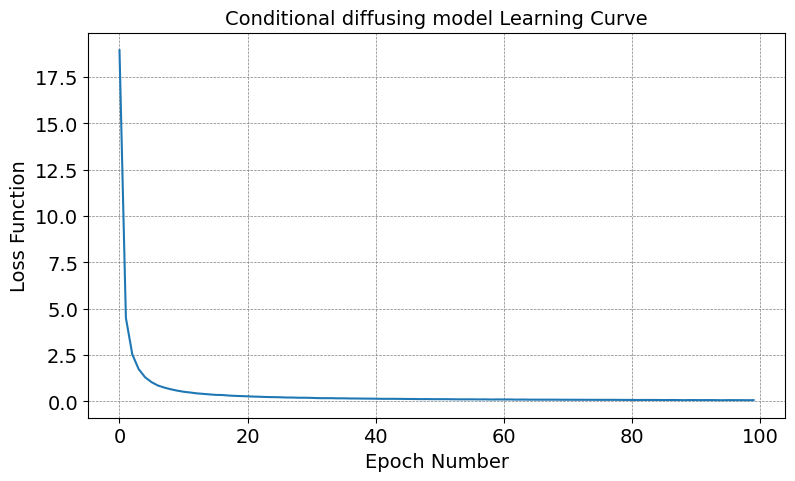

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Тестим


# Трейн

In [ ]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim)
X_fake_train = quantile_transformer.inverse_transform(X_fake_train)

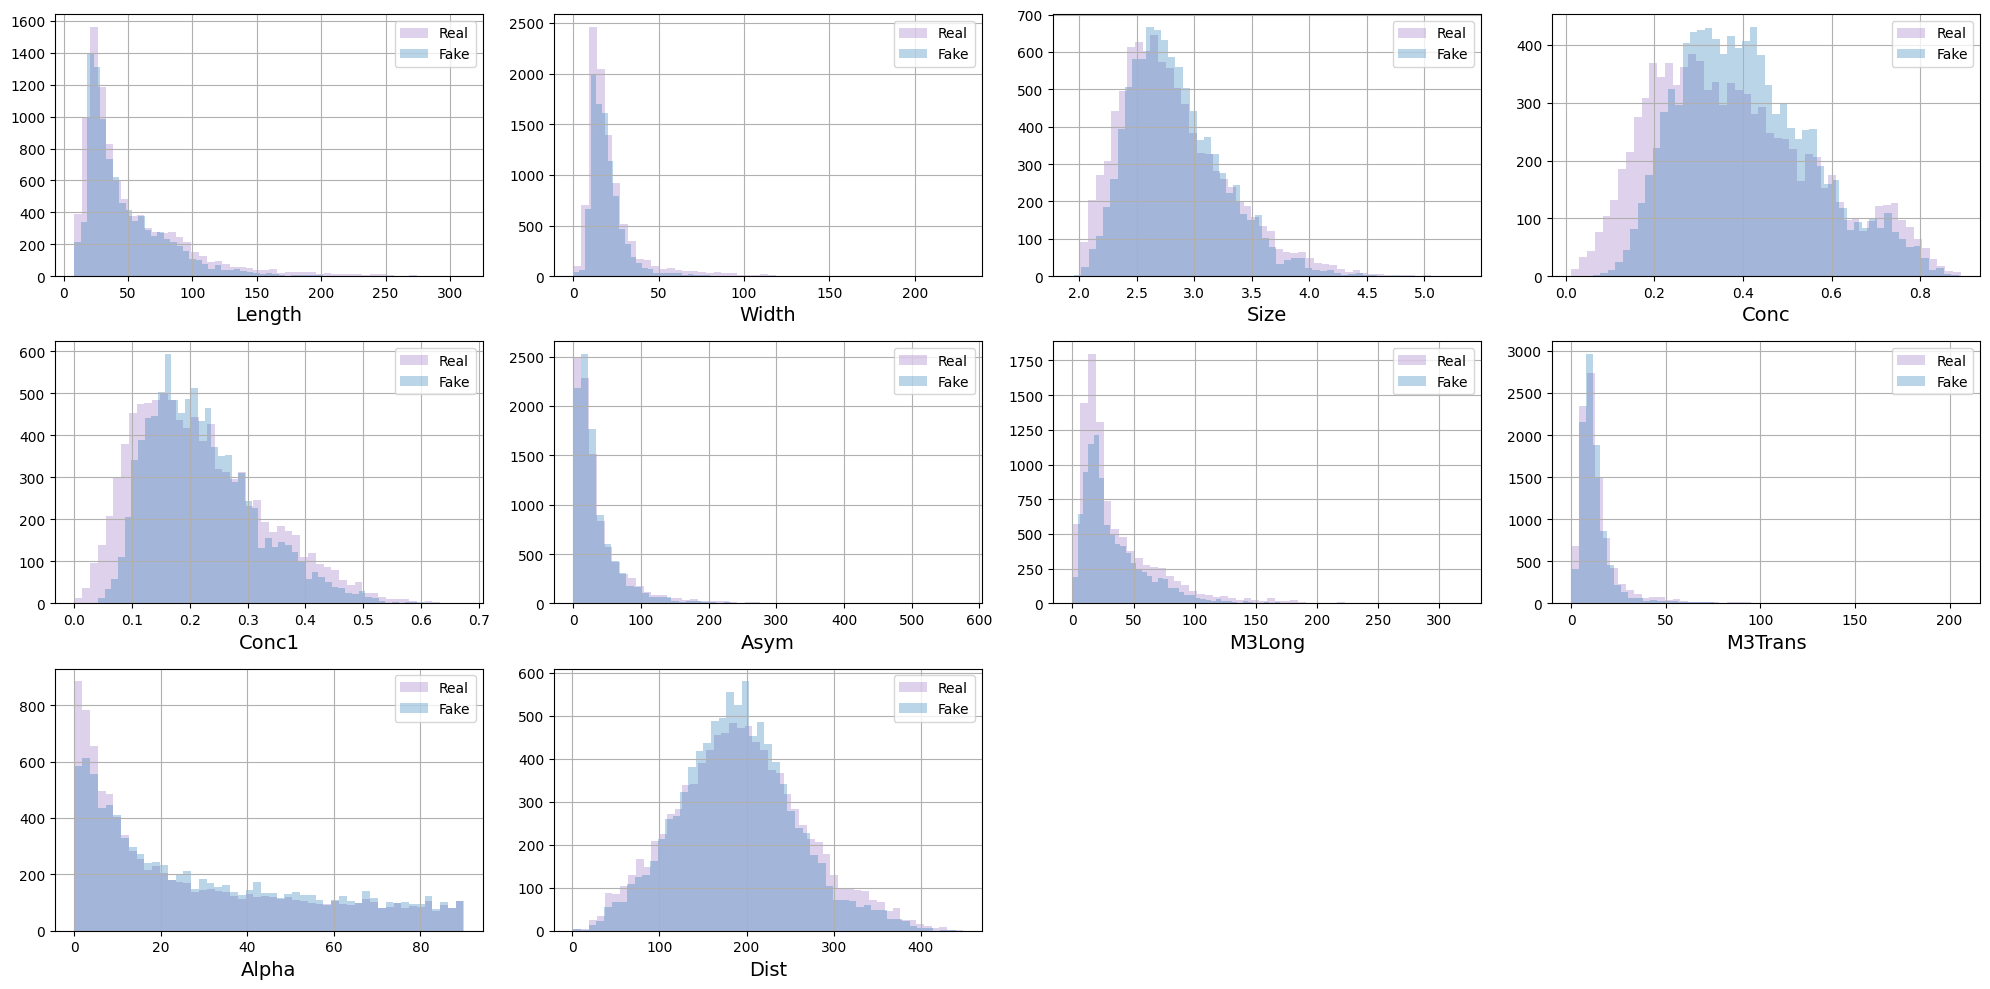

In [ ]:
plot_hists(X_train_inv, X_fake_train, names, label1="Real", label2="Fake", bins=50)

# Тест

In [ ]:
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim)
X_fake_test = quantile_transformer.inverse_transform(X_fake_test)

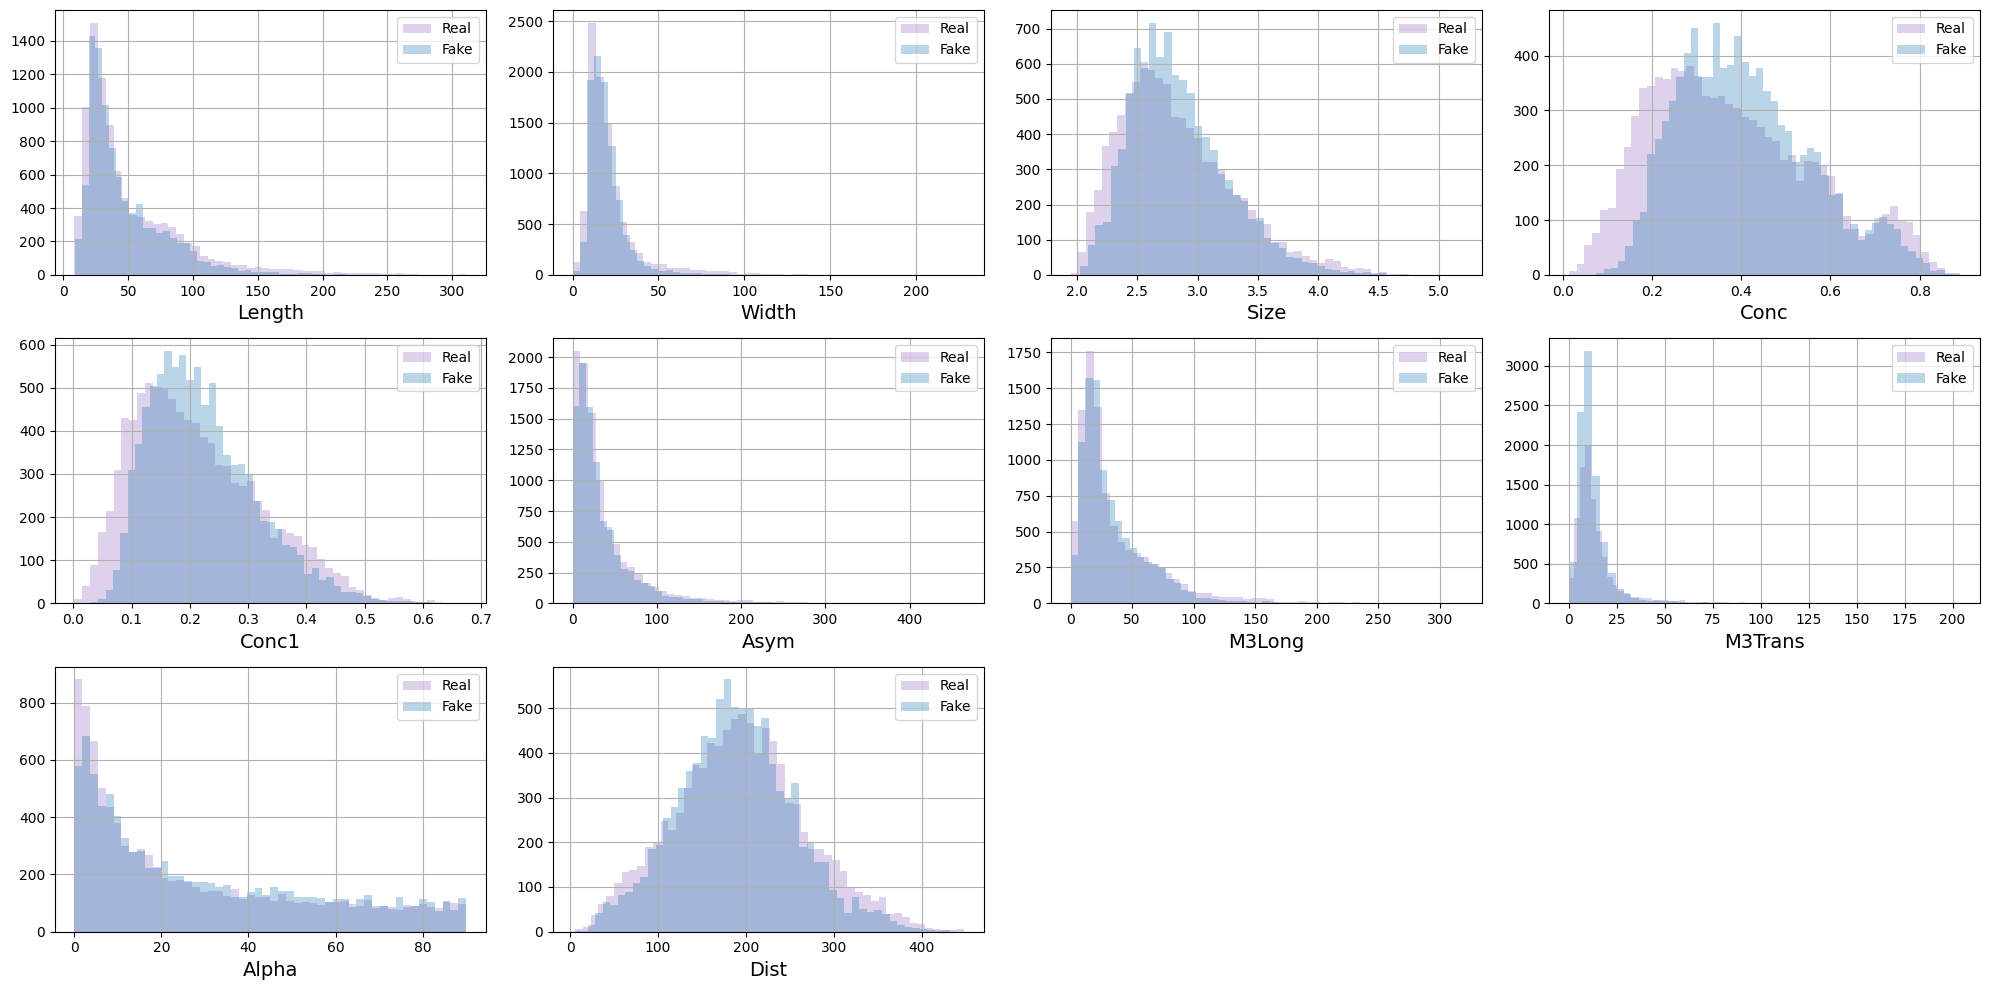

In [ ]:
plot_hists(X_test_inv, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [ ]:
XX_train = np.concatenate((X_fake_train, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.9806921708401471
